# CartPole Warmup

In [9]:
# Imports.
import sys
print(sys.version)
print()
from collections import deque
import matplotlib.pyplot as plt
import gym
import random
import time
import numpy as np
from tqdm.notebook import trange
import tensorflow as tf
print("Tensorflow", tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
print(tf.config.list_physical_devices('GPU'))
print()

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]

Tensorflow 2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1, 1))
display.start()

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

[-0.19268856 -1.95100128  0.23119434  3.03806047]
1.0


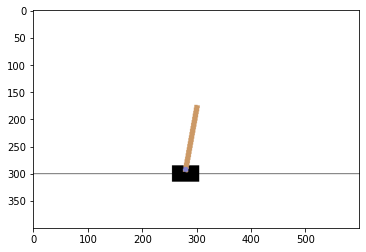

In [3]:
%matplotlib inline
env = gym.make('CartPole-v0')
for _ in range(1):
    env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        observation, reward, done, info = env.step(0) # take a random action

env.close()
print(observation)
print(reward)

## Deep Q Network Agent

In [4]:
class Agent:
    def __init__(self, state_num, action_num):
        self.action_num = action_num
        self.state_num = state_num
        self.gamma = 0.95 # Discount rate.
        self.batch = 32 # Number of replayed experinces batched together.
        self.experiences = deque(maxlen=400) # Total number of experiences.
        
        # Create NN that will act as function approximator for Q[s,a].
        self.model = keras.Sequential()
        # First dense layer with relu activation.
        self.model.add(layers.Dense(24, input_dim=state_num, activation="relu"))
        self.model.add(layers.Dense(24, activation="relu"))
        self.model.add(layers.Dense(action_num, activation="relu"))
        
        # Loss function.
        self.model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.001))
        
        self.model.summary()
        
        # Create target model copy.
        self.target_model = keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        
    def ExploitAction(self, state):
        state = np.reshape(state, [1, self.state_num])
        # Take the best possible action.
        action_values = self.model.predict(state)
        exploit_action_index = np.argmax(action_values[0])
        return exploit_action_index
    
    def ExploreAction(self):
        # Take a random action to explore the [s,a] space.
        return np.random.choice(self.action_num, 1)[0]
    
    def AddExperience(self, s, a, r, s2, episode_over):
        s = np.reshape(s, [1, self.state_num])
        s2 = np.reshape(s2, [1, self.state_num])
        # Add experience to a que.
        self.experiences.append((s, a, r, s2, episode_over))
        
    def UpdateQ(self):
        # Don't start training until experiences is 25% full.
        if (len(self.experiences) < (self.experiences.maxlen/4)):
            return
        
        # Select from random experiences excluding most recent.
        selected_experiences = random.sample(list(self.experiences)[0:-1], self.batch-1)
        # Append most recent experience.
        selected_experiences.append(self.experiences[-1])
        

        # Collect all next state Q values.
        s_t1s = np.zeros([self.batch, self.state_num])
        for i in range(len(selected_experiences)):
            s_t1s[i] = selected_experiences[i][0]
        
        a_t1_values = self.target_model.predict(s_t1s)
        max_a_t1_value = np.amax(a_t1_values, axis=1)
        
        targets = np.zeros([self.batch, 1])
        states = np.zeros([self.batch, self.state_num])
        i = 0
        for s_t0, a_t0, r_t0, s_t1, over in selected_experiences:
            states[i] = s_t0
            if (not over):
                targets[i] = r_t0 + self.gamma*max_a_t1_value[i]
            else:
                targets[i] = r_t0
            i+=1

        self.model.fit(states, targets, verbose=0)

In [5]:
def PlayEpisode(env, agent, epsilon):
    # Reset playing environment.
    observation = env.reset()
    
    total_episode_reward = 0
    
    episode_done = False
    while not episode_done:
        # Explore or exploit.
        if (random.random() < epsilon):
            # Explore.
            action = agent.ExploreAction()
        else:
            # Exploit.
            action = agent.ExploitAction(observation)
        
        # Perform action and state transition.
        next_observation, reward, episode_done, info = env.step(action)
        total_episode_reward += reward
        
        # Punish ending early.
        if episode_done and (total_episode_reward < 500):
            reward -= 300
            
        # Add to step to experiences.
        agent.AddExperience(observation, action, reward, next_observation, episode_done)
        # Train.
        agent.UpdateQ()
        
        # Next observation becomes current.
        observation = next_observation
    return total_episode_reward

### Create Agent and Environment

In [6]:
env = gym.make('CartPole-v1')
print("Observation Space " + str(len(env.observation_space.sample())))
print("Action Space " + str(env.action_space.n))

agent = Agent(len(env.observation_space.sample()), env.action_space.n)

Observation Space 4
Action Space 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


## Run Training

  0%|          | 0/100 [00:00<?, ?it/s]


Episode 0 Epsilon 1.0 Reward 13.0
Elapsed time: 0.75

Episode 25 Epsilon 0.2 Reward 9.0
Elapsed time: 78.06

Episode 50 Epsilon 0.14 Reward 85.0
Elapsed time: 34.49

Episode 75 Epsilon 0.11 Reward 14.0
Elapsed time: 21.75


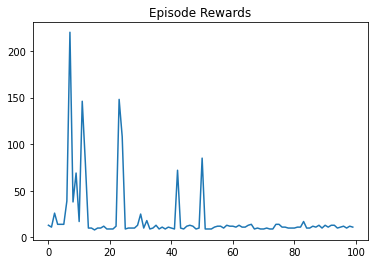

In [10]:
episode_num = 100
episode_rewards = np.zeros(episode_num)

start = time.time()
for i in trange(episode_num):
    # Decay epsilon.
    eps = 1.0/np.sqrt(i+1)
    
    # Play episode.
    episode_rewards[i] = PlayEpisode(env, agent, eps)
    #print('.', end='')
    if i%25 == 0:
        agent.target_model.set_weights(agent.model.get_weights())
        print("\nEpisode", i, "Epsilon", round(eps,2), "Reward", episode_rewards[i])
        print("Elapsed time:", round(time.time() - start, 2))
        start = time.time()

plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.show()